In [1]:
!pip3 install torch torchvision

# Homework 5 (Fashion MNist)

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="/mldata/FashionMNIST",
    train=True,
    download=True,
    transform=ToTensor()
)


test_data = datasets.FashionMNIST(
    root="/mldata/FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

## Visualize Samples of the Training Data

image_shape: torch.Size([1, 28, 28]) label_number: 0 label_name: T-Shirt
image_shape: torch.Size([1, 28, 28]) label_number: 0 label_name: T-Shirt
image_shape: torch.Size([1, 28, 28]) label_number: 1 label_name: Trouser
image_shape: torch.Size([1, 28, 28]) label_number: 1 label_name: Trouser
image_shape: torch.Size([1, 28, 28]) label_number: 2 label_name: Pullover
image_shape: torch.Size([1, 28, 28]) label_number: 2 label_name: Pullover
image_shape: torch.Size([1, 28, 28]) label_number: 3 label_name: Dress
image_shape: torch.Size([1, 28, 28]) label_number: 3 label_name: Dress
image_shape: torch.Size([1, 28, 28]) label_number: 4 label_name: Coat
image_shape: torch.Size([1, 28, 28]) label_number: 4 label_name: Coat
image_shape: torch.Size([1, 28, 28]) label_number: 5 label_name: Sandal
image_shape: torch.Size([1, 28, 28]) label_number: 5 label_name: Sandal
image_shape: torch.Size([1, 28, 28]) label_number: 6 label_name: Shirt
image_shape: torch.Size([1, 28, 28]) label_number: 6 label_name

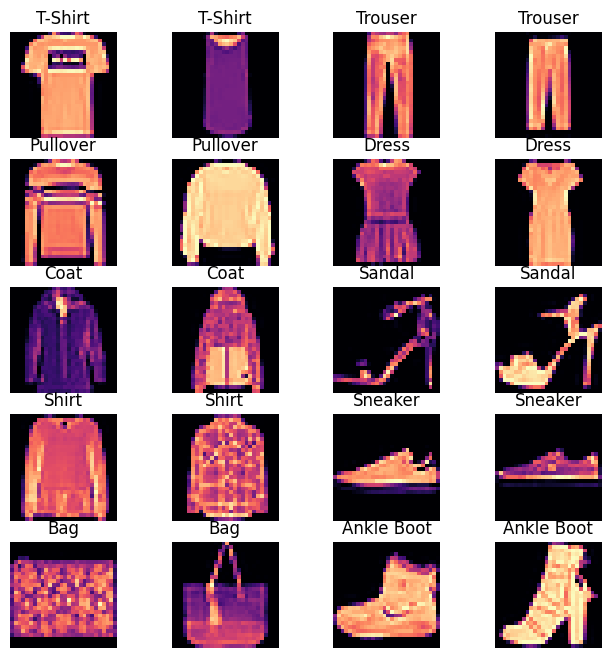

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

tracking_dict = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
}

img_count = 0

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 5

for label in range(10):
    while tracking_dict[label] < 2 and img_count < 20:
        for idx, (img, lbl) in enumerate(training_data):
            if lbl == label:
                tracking_dict[label] += 1
                img_count += 1
                print("image_shape:", img.size(), "label_number:", lbl, "label_name:", labels_map[lbl])
                figure.add_subplot(rows, cols, img_count)
                plt.title(labels_map[lbl])
                plt.axis("off")
                plt.imshow(img.squeeze(), cmap="magma")
                if tracking_dict[label] == 2 or img_count == 20:
                    break

plt.show()


## Implement Neural Network 

In [4]:
import torch.nn as nn
import torch.optim as optim

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 500)  # First layer with 500 neurons
        self.relu1 = nn.ReLU()  # ReLU activation for first layer
        self.layer2 = nn.Linear(500, 100)  # Second layer with 100 neurons
        self.relu2 = nn.ReLU()  # ReLU activation for second layer
        self.output = nn.Linear(100, 10)  # Final layer with 10 neurons
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for final layer

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=500, out_features=100, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


## Initialize DataLoaders

In [9]:
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

## Implement Train/Test Functions

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    
    for batch, (X, y) in enumerate(dataloader):        
        # Compute prediction and loss
        X = X.cuda()
        y = y.cuda()
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update training accuracy
        pred_classes = pred.argmax(dim=1)
        correct += (pred_classes == y).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    training_accuracy = correct / size
    
    print(f'Training Accuracy: {training_accuracy:.6f}')
    return training_accuracy

In [11]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.cuda()
            y = y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    testing_accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*testing_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return testing_accuracy

## Test the Model on Data

In [12]:
def run_model(epochs, train, test, learning_rate):
    
    training_accuracy_lst = []
    testing_accuracy_lst = []
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        training_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
        training_accuracy_lst.append(training_accuracy)
        
        testing_accuracy = test_loop(test_dataloader, model, loss_fn)
        testing_accuracy_lst.append(testing_accuracy)
    print("Done!")
    
    return training_accuracy_lst, testing_accuracy_lst

## Plotting Accuracy 

In [13]:
def plot_accuracy(training_accuracy, testing_accuracy, learning_rate):
    plt.figure()
    plt.plot(training_accuracy_lst, label='Training Accuracy', color='Red')
    plt.plot(testing_accuracy_lst, label='Testing Accuracy', color='Blue')
    plt.title(f'Training and Testing Accuracy for Learning Rate: {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Plot Training/Testing Accuracy

### Learning Rate = 1e-6

In [14]:
learning_rate = 1e-6
epochs = 10

In [15]:
training_accuracy_lst, testing_accuracy_lst = run_model(epochs, train_loop, test_loop, learning_rate)

Epoch 1
-------------------------------
loss: 2.301242  [    0/60000]
loss: 2.302749  [ 6400/60000]
loss: 2.302739  [12800/60000]
loss: 2.304869  [19200/60000]
loss: 2.304209  [25600/60000]
loss: 2.303295  [32000/60000]
loss: 2.303051  [38400/60000]
loss: 2.303775  [44800/60000]
loss: 2.301904  [51200/60000]
loss: 2.303493  [57600/60000]
Training Accuracy: 0.099167
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.036157 

Epoch 2
-------------------------------
loss: 2.302904  [    0/60000]
loss: 2.303385  [ 6400/60000]
loss: 2.302895  [12800/60000]
loss: 2.306144  [19200/60000]
loss: 2.302990  [25600/60000]
loss: 2.303253  [32000/60000]
loss: 2.303416  [38400/60000]
loss: 2.303614  [44800/60000]
loss: 2.304949  [51200/60000]
loss: 2.301898  [57600/60000]
Training Accuracy: 0.099167
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.036157 

Epoch 3
-------------------------------
loss: 2.303154  [    0/60000]
loss: 2.304719  [ 6400/60000]
loss: 2.303935  [12800/60000]
loss: 2.302786  [19200/60000]


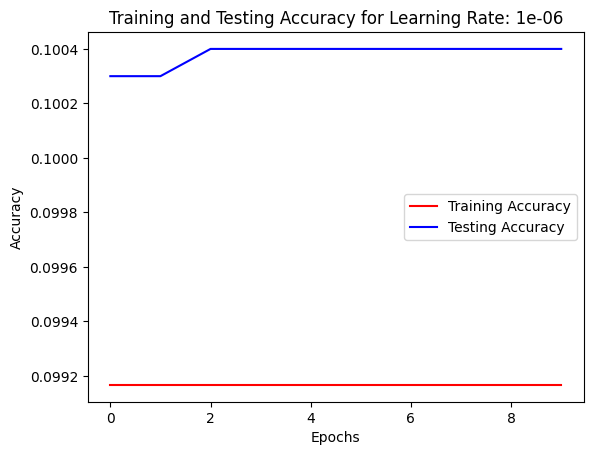

In [16]:
plot_accuracy(training_accuracy_lst, testing_accuracy_lst, learning_rate)

### Learning Rate = 1e-2

In [17]:
learning_rate = 1e-2
epochs = 10

In [18]:
training_accuracy_lst, testing_accuracy_lst = run_model(epochs, train_loop, test_loop, learning_rate)

Epoch 1
-------------------------------
loss: 2.302907  [    0/60000]
loss: 2.304216  [ 6400/60000]
loss: 2.300553  [12800/60000]
loss: 2.298265  [19200/60000]
loss: 2.298888  [25600/60000]
loss: 2.295978  [32000/60000]
loss: 2.295628  [38400/60000]
loss: 2.295782  [44800/60000]
loss: 2.289798  [51200/60000]
loss: 2.289235  [57600/60000]
Training Accuracy: 0.204300
Test Error: 
 Accuracy: 34.2%, Avg loss: 0.035943 

Epoch 2
-------------------------------
loss: 2.289914  [    0/60000]
loss: 2.286080  [ 6400/60000]
loss: 2.283156  [12800/60000]
loss: 2.281708  [19200/60000]
loss: 2.277093  [25600/60000]
loss: 2.272184  [32000/60000]
loss: 2.264898  [38400/60000]
loss: 2.256261  [44800/60000]
loss: 2.238053  [51200/60000]
loss: 2.205036  [57600/60000]
Training Accuracy: 0.405000
Test Error: 
 Accuracy: 35.5%, Avg loss: 0.034803 

Epoch 3
-------------------------------
loss: 2.240355  [    0/60000]
loss: 2.164305  [ 6400/60000]
loss: 2.191054  [12800/60000]
loss: 2.110771  [19200/60000]


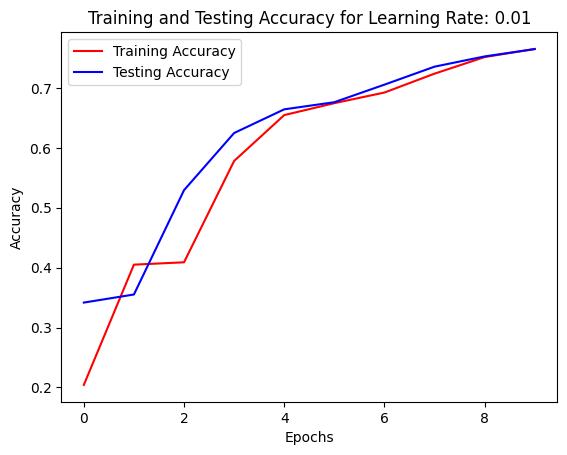

In [19]:
plot_accuracy(training_accuracy_lst, testing_accuracy_lst, learning_rate)

### Learning Rate = 1

In [20]:
learning_rate = 1
epochs = 10

In [21]:
training_accuracy_lst, testing_accuracy_lst = run_model(epochs, train_loop, test_loop, learning_rate)

Epoch 1
-------------------------------
loss: 1.708813  [    0/60000]
loss: 1.662243  [ 6400/60000]
loss: 1.770643  [12800/60000]
loss: 1.714617  [19200/60000]
loss: 1.644706  [25600/60000]
loss: 1.833013  [32000/60000]
loss: 1.621907  [38400/60000]
loss: 1.789820  [44800/60000]
loss: 1.648980  [51200/60000]
loss: 1.720887  [57600/60000]
Training Accuracy: 0.749950
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.027310 

Epoch 2
-------------------------------
loss: 1.792968  [    0/60000]
loss: 1.692954  [ 6400/60000]
loss: 1.697098  [12800/60000]
loss: 1.754352  [19200/60000]
loss: 1.752936  [25600/60000]
loss: 1.553079  [32000/60000]
loss: 1.819166  [38400/60000]
loss: 1.747300  [44800/60000]
loss: 1.612120  [51200/60000]
loss: 1.664175  [57600/60000]
Training Accuracy: 0.783250
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.026836 

Epoch 3
-------------------------------
loss: 1.706567  [    0/60000]
loss: 1.632335  [ 6400/60000]
loss: 1.659776  [12800/60000]
loss: 1.738999  [19200/60000]


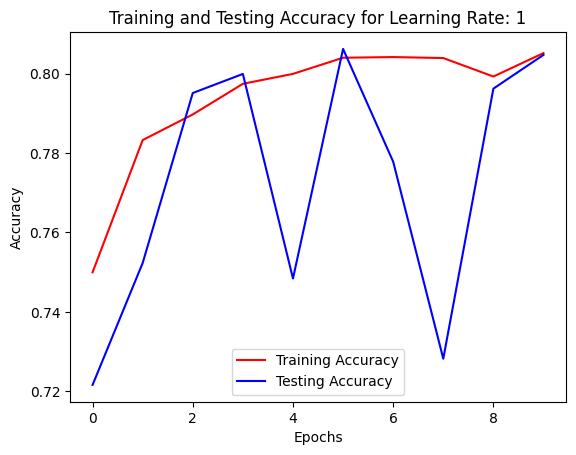

In [22]:
plot_accuracy(training_accuracy_lst, testing_accuracy_lst, learning_rate)

## Observations

I noticed that the model's accuracy improved very little with the learning rate of 1e-6, as denoted by the graph. The training accuracy improved steadily but slowly, but our testing accuracy did not change for the most part, with a final value of 11.6%. However, the models accuracy with a learning rate of 0.01 increased substantially, both training and testing, with a final testing accuracy value of 71.2%. With this learning rate our model generalized better to new data significantly better than with the previous learning rate. With our final learning rate of 1, the model performed its best, however the testing accuracy oscillated, it slightly decreased during epochs 1-2 and 3-4 and 8-9, and had a final testing accuracy of 79.7%.

## Save Model

In [23]:
torch.save(model, '/mldata/nikhilkuniyil')

## Total Number of Parameters

Each neuron contains a bias, which is added to the product of the layer's input and the number of neurons.

Input: 
$$
28 \cdot 28 = 784
$$

Layer 1, 500 neurons: 
$$
(784) \cdot 500 = 392000
\\
392000 + 500 = 392500
$$

Trainable parameters of Layer 1: $392500$
$$
\\
\\
$$


Layer 2, 100 neurons:
$$
500 \cdot 100 = 50000
\\
50000 + 100 = 50100
$$

Trainable parameters of Layer 2: $50100$
$$
\\
\\
$$

Layer 3, 10 neurons:
$$
100 \cdot 10 = 1000
\\
1000 + 10 = 1010
$$

Trainable parameters of Layer 3: $1010$
$$
\\
\\
$$

Total:
$$392500 + 50100 + 1010 = 443610$$
$$
\\
\\
$$

The network contains $443610$ trainable parameters

## Visualize Correctly/Incorrectly Classified Samples

In [24]:
def show_predictions(model, test_loader, label_map):
    correct = [] # initialize list of correctly classified images
    incorrect = [] # initialize list of incorrectly classified images
    
    with torch.no_grad():
        for images, labels in test_loader: # Iterate in batches of 64
            images = images.cuda()
            labels = labels.cuda()
            
            output = model(images) 
            _,pred = torch.max(output, 1) # compute our predictions, pred is a tensor of size 64 with range (0,9)
            
            for i in range(len(labels)): # iterate throughout our labels in the current batch
                if pred[i].item() == labels[i].item(): # compare predicted value to the actual label
                    correct.append((images[i], labels[i])) # add to list of correctly classified images
                else:
                    incorrect.append((images[i], labels[i]))# add to list of incorrectly classified images
                    
    tracking_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0
    }
    
    
    img_count_correct = 0
    img_count_incorrect = 0
    
    # plot correctly classified images
    for img, lbl in correct:
        if (tracking_dict[lbl.item()] < 2):
            img = img.squeeze()
            img = img.detach().cpu().numpy() 
            plt.imshow(img)
            plt.title(f'Correct: {label_map[lbl.item()]}')
            plt.show()
            
            tracking_dict[lbl.item()] += 1
            img_count_correct += 1
    
    tracking_dict = {key: 0 for key in tracking_dict}
    
    # plot incorrectly classified images
    for img, lbl in incorrect:
        if (tracking_dict[lbl.item()] < 2):
            img = img.squeeze()
            img = img.detach().cpu().numpy() 
            plt.imshow(img, cmap='magma')
            plt.title(f'Incorrect: {label_map[lbl.item()]}')
            plt.show()
            
            tracking_dict[lbl.item()] += 1
            img_count_incorrect += 1

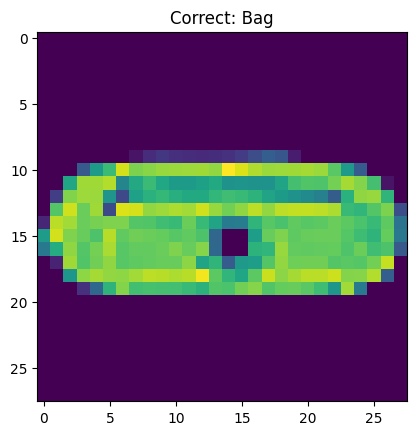

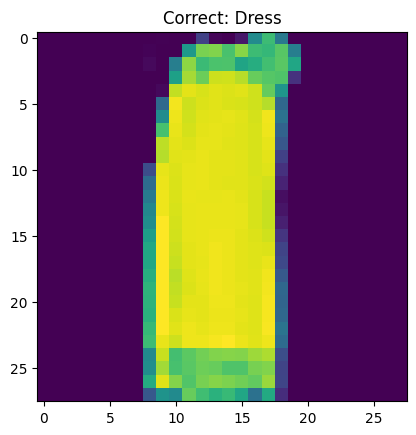

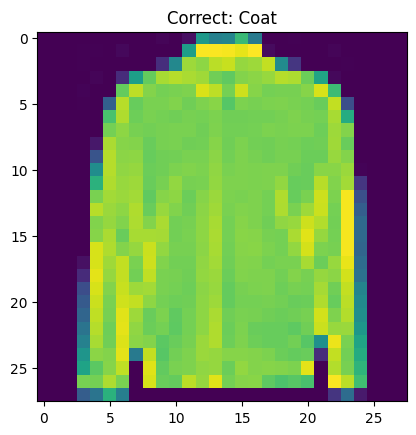

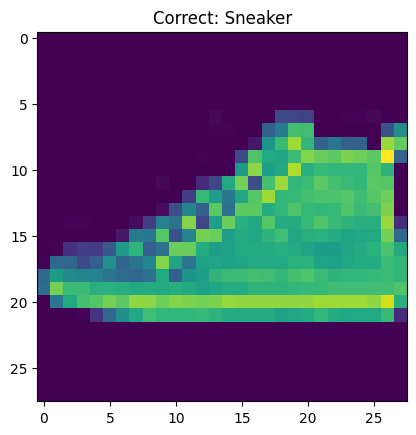

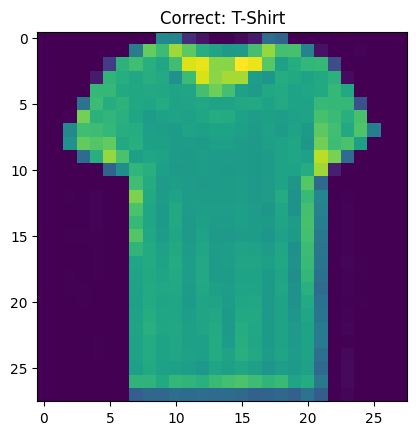

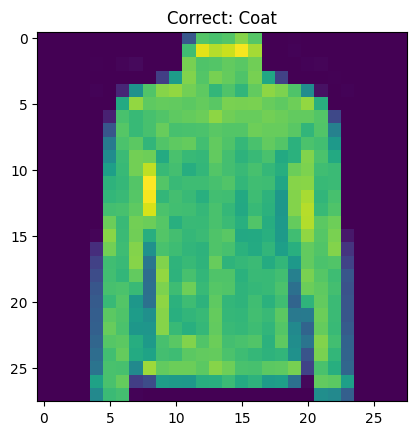

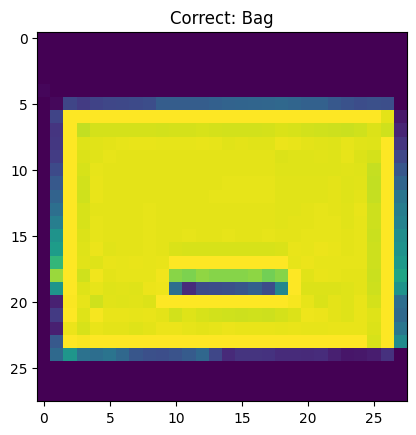

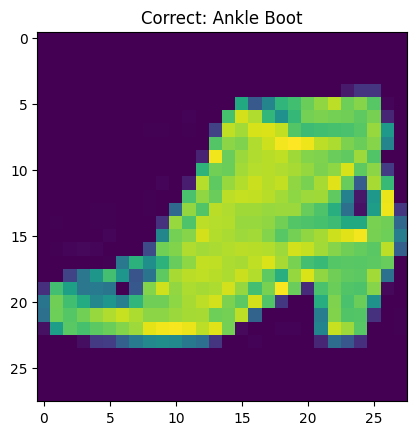

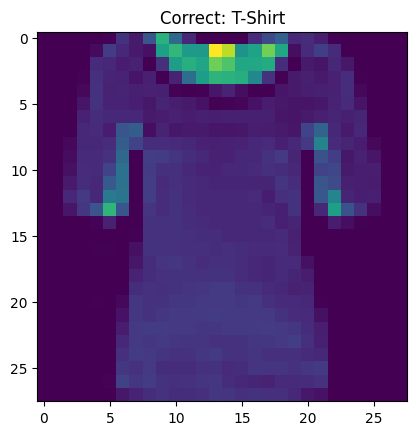

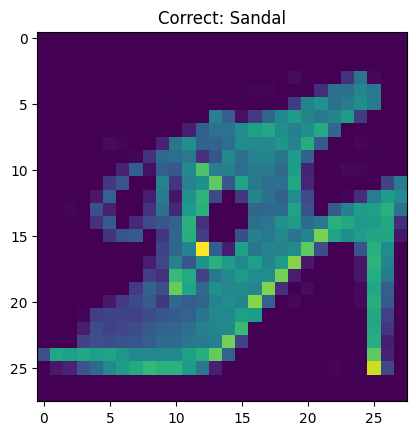

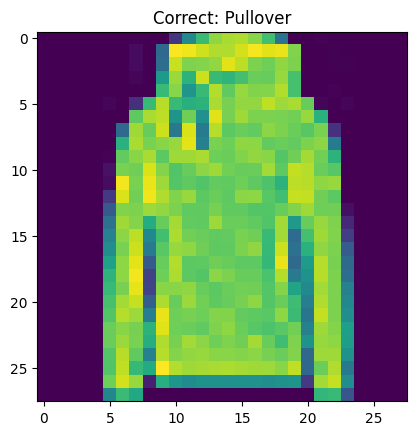

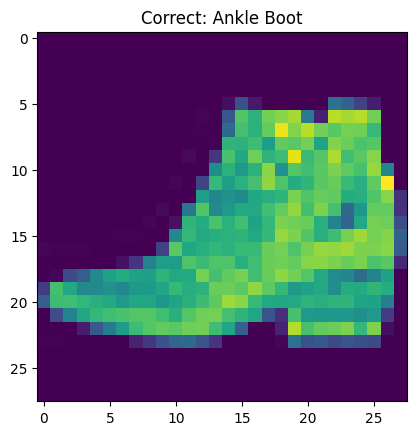

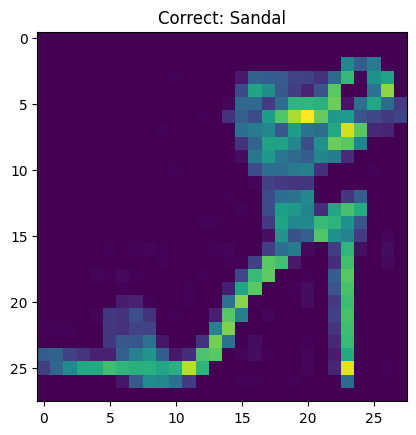

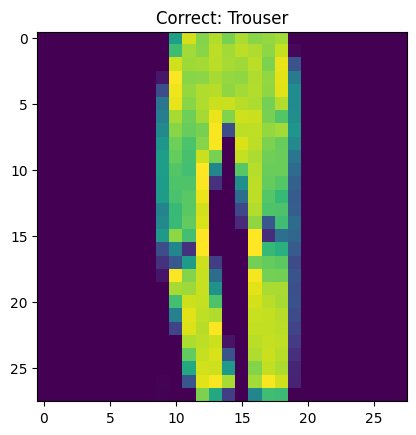

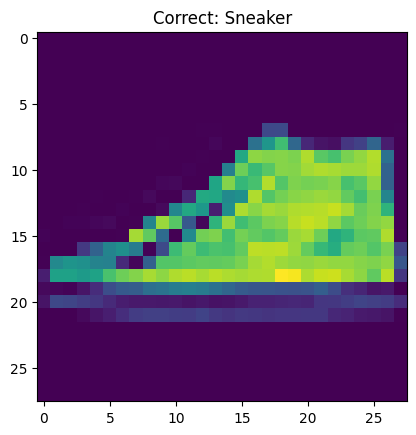

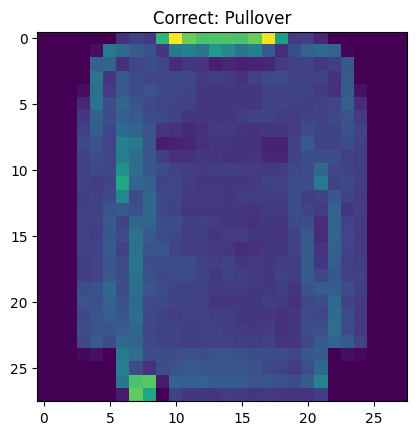

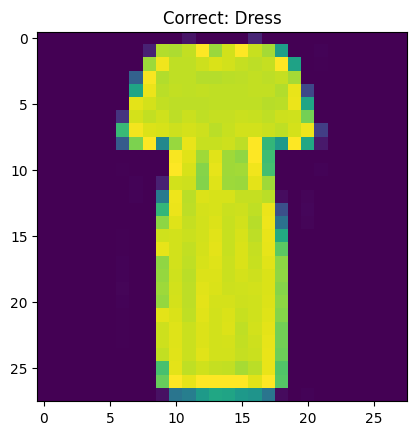

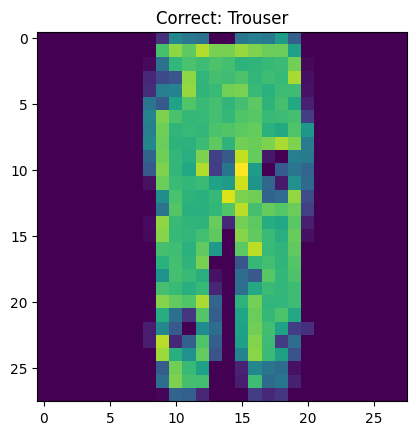

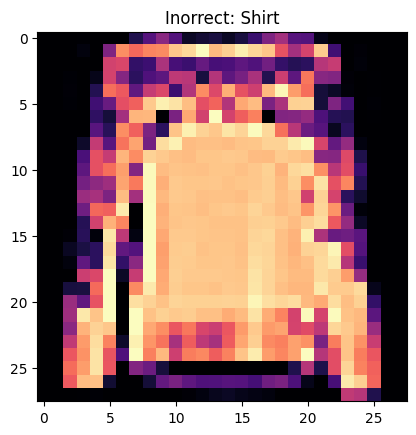

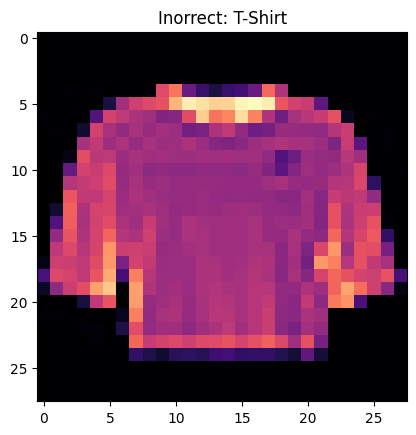

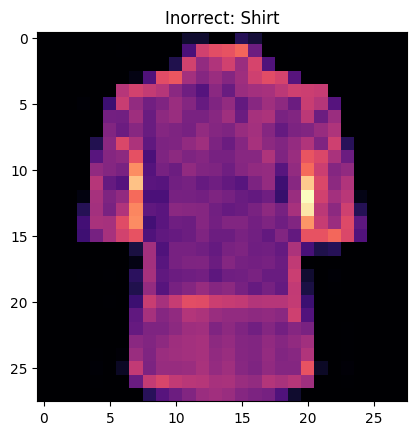

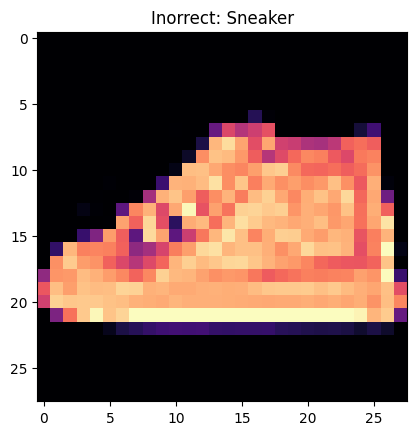

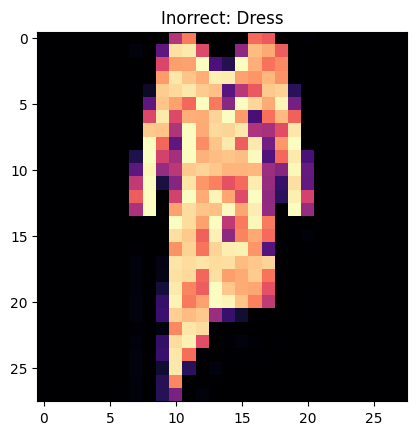

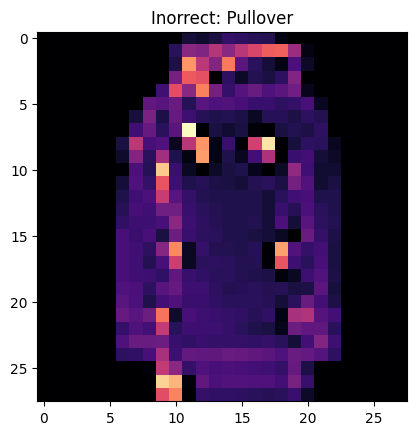

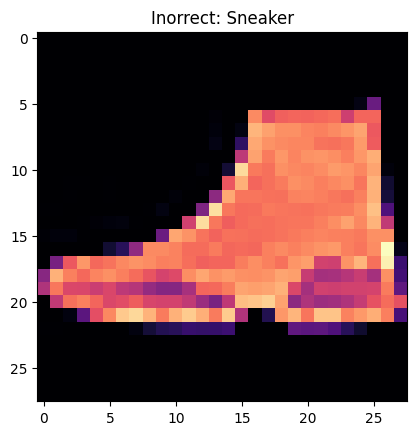

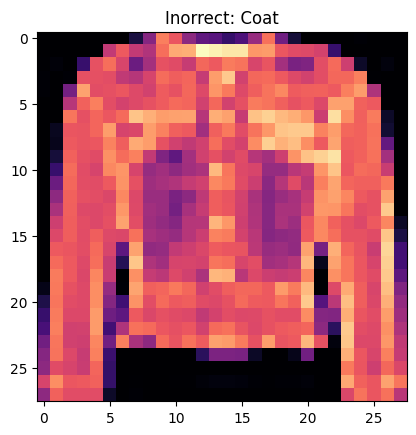

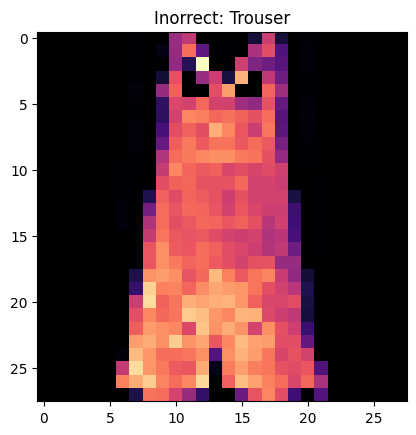

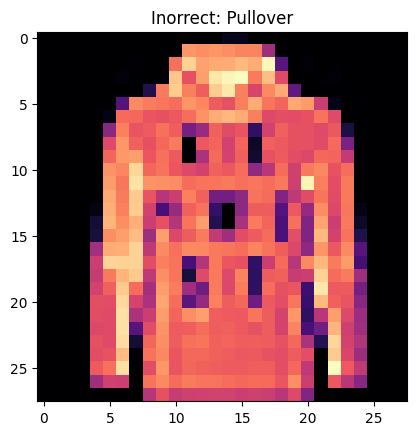

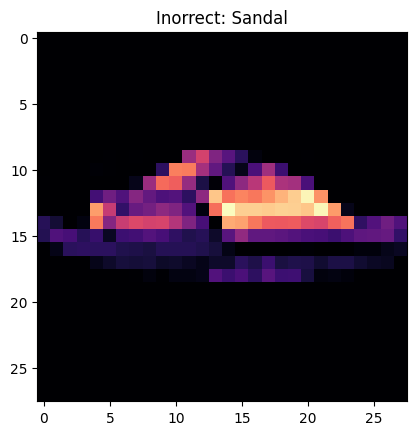

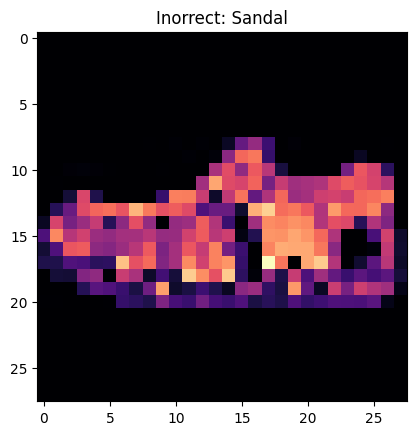

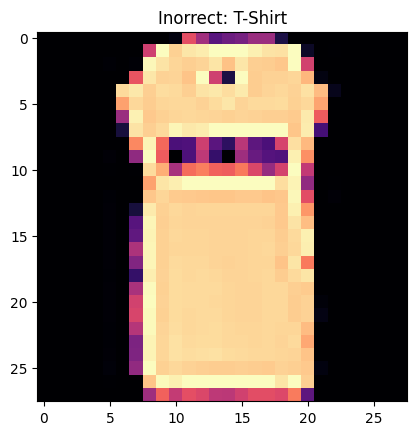

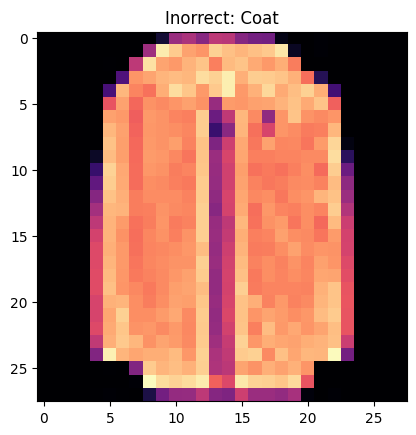

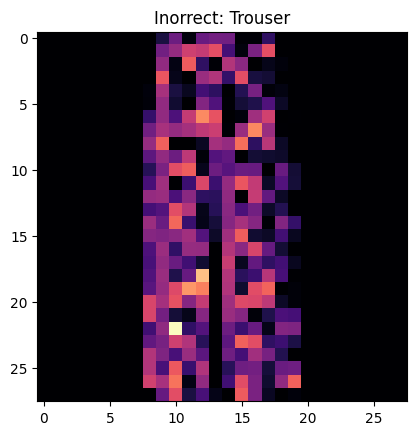

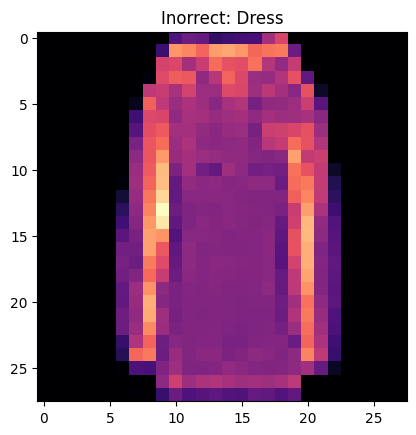

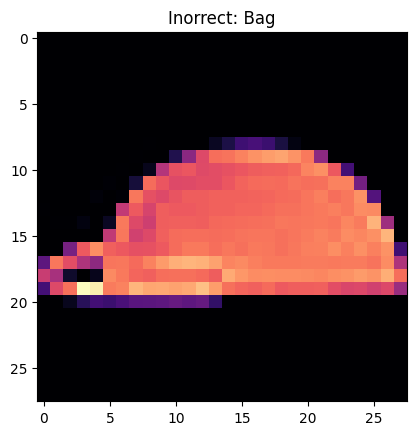

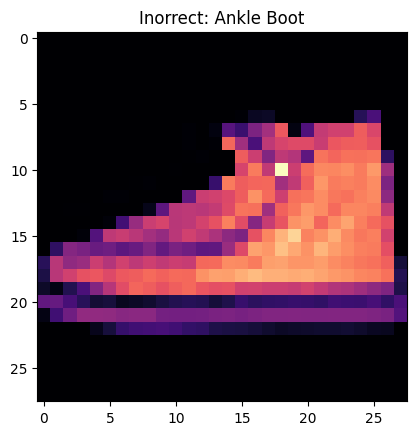

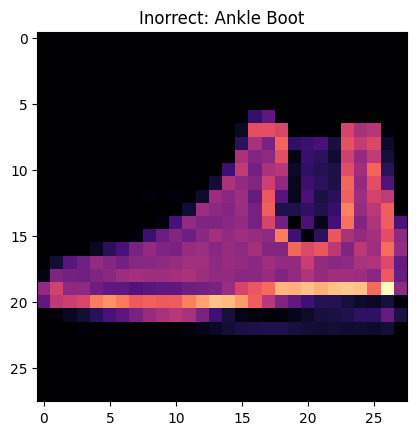

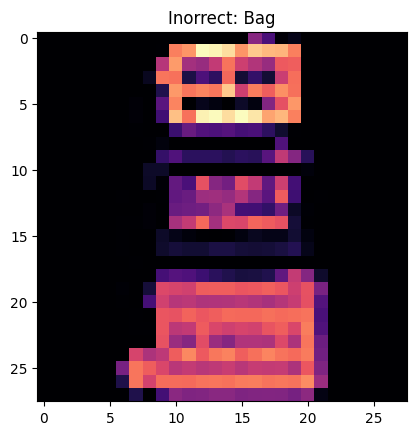

In [25]:
show_predictions(model, test_dataloader, labels_map)

The model may have misclassified the above images due to its inability to learn certain edge cases/patterns present in the images themeselves. When we train our CNN, throughout each epoch our model learns each aspect of our image including various patterns such as edges, corners, curves. etc. to the best of its ability. However, when we come across two similar images, the model may recognize similar features form one class to another and use that to make an incorrect prediction based on the patterns learned during training. We can mitigate this by increasing our training dataset, or increasing the number of epochs that we trained our model. 